In [1]:
import os
import json

from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import torch


from bigram_estimator import getWordDict, getNgramDict, pLM
from generate_watermark import load_model, generate
from likelihood_ratio_test import L_Gw

/Users/wayne/miniconda3/envs/lm-watermarking1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = Namespace()

arg_dict = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-125m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args.__dict__.update(arg_dict)

args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])


In [3]:
model, tokenizer, device = load_model(args)

In [4]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)


In [5]:
times = 1 #1000
tokd_input, watermark_processor, output, corpus_without_watermark, corpus_with_watermark, _ = generate("",
                                                                    args,
                                                                    model=model,
                                                                    device=device,
                                                                    tokenizer=tokenizer,
                                                                    times=times)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-125m', load_fp16=False, prompt_max_length=None, max_new_tokens=200, generation_seed=123, use_sampling=True, n_beams=1, sampling_temp=0.7, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=2.0, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


To load whole corpora. Only use when analysing over larger corpora

In [ ]:
# path_watermarked = '/data/corpora_with_watermark/'
# json_file_names = [filename for filename in os.listdir(path_watermarked) if filename.endswith('.json')]
# # print(json_file_names)
# corpus_with_watermark = []
# for json_file_name in json_file_names:
#     with open(os.path.join(path_watermarked, json_file_name)) as json_file:
#         foo = json.load(json_file)
#     corpus_with_watermark += foo

# path_nonwatermarked = '/data/corpora_without_watermark/'
# json_file_names = [filename for filename in os.listdir(path_nonwatermarked) if filename.endswith('.json')]
# corpus_without_watermark = []
# for json_file_name in json_file_names:
#     with open(os.path.join(path_nonwatermarked, json_file_name)) as json_file:
#         foo = json.load(json_file)
#     corpus_without_watermark += foo

In [7]:
# word_dict_w = getWordDict(corpus_with_watermark, tokenizer)
# n_gram_dict_w = getNgramDict(corpus_with_watermark, tokenizer)

# word_dict_nw = getWordDict(corpus_without_watermark, tokenizer)
# n_gram_dict_nw = getNgramDict(corpus_without_watermark, tokenizer)

## Computing $\sup_{\theta \in \Theta} L(\theta)$

In [59]:
# delta MUST BE A SCALAR!!!!


def L_Gw(delta, w, corpus, watermark_processor, tokenizer, model):
    expdelta = torch.exp(delta)
    greenlist_w, redlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode(w)), get_redlist=True)
    greenlist_w = tokenizer.convert_ids_to_tokens(greenlist_w)
    redlist_w = tokenizer.convert_ids_to_tokens(redlist_w)

    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(corpus)
    tokenized_corpus = list(zip(*words_with_offsets))[0]
    
    corpus_t = tokenizer.encode(corpus, add_special_tokens=False)

    with torch.inference_mode():
        output = model(torch.tensor([corpus_t]))
    soft_logits = torch.softmax(output.logits[0], dim=1)

    green = torch.zeros(output.logits.size(1))
    red = torch.zeros(output.logits.size(1))

    for wdash in greenlist_w:
        green += pLM(wdash, tokenizer, soft_logits)

    for wdash in redlist_w:
        red += pLM(wdash, tokenizer, soft_logits)

    deltas = torch.zeros(output.logits.size(1))
    for i in range(output.logits.size(1)):
        if tokenized_corpus[i] in greenlist_w:
            deltas[i] = deltas[i] + delta

    L = torch.sum(deltas - torch.log(expdelta * green + red))
    return L

In [73]:
corpus_without_watermark[0].split("   ")[2]

'"I don\'t know anything about music"'

In [75]:
deltaarr = torch.linspace(0, 1, 50)
# print(deltaarr.size(0))
w = 'Ġup'
#sentence = "The quick brown fox jumps over the lazy dog"
sentences = corpus_without_watermark[0].split("   ")

Larr = torch.zeros(deltaarr.size(0))
for j in range(len(sentences)):
    for i in range(deltaarr.size(0)):
        #Larr = L_Gw(delta, w, sentence, watermark_processor, tokenizer, model)
        Larr[i] = L_Gw(deltaarr[i], w, sentences[j], watermark_processor, tokenizer, model)
Larr

tensor([ 5.1911e-04, -2.7738e-02, -5.7575e-02, -8.9007e-02, -1.2205e-01,
        -1.5671e-01, -1.9300e-01, -2.3095e-01, -2.7055e-01, -3.1183e-01,
        -3.5480e-01, -3.9946e-01, -4.4584e-01, -4.9394e-01, -5.4377e-01,
        -5.9535e-01, -6.4869e-01, -7.0380e-01, -7.6070e-01, -8.1938e-01,
        -8.7987e-01, -9.4217e-01, -1.0063e+00, -1.0723e+00, -1.1401e+00,
        -1.2097e+00, -1.2813e+00, -1.3547e+00, -1.4299e+00, -1.5071e+00,
        -1.5862e+00, -1.6671e+00, -1.7500e+00, -1.8349e+00, -1.9216e+00,
        -2.0103e+00, -2.1009e+00, -2.1935e+00, -2.2880e+00, -2.3845e+00,
        -2.4830e+00, -2.5834e+00, -2.6858e+00, -2.7902e+00, -2.8966e+00,
        -3.0050e+00, -3.1154e+00, -3.2278e+00, -3.3422e+00, -3.4586e+00])

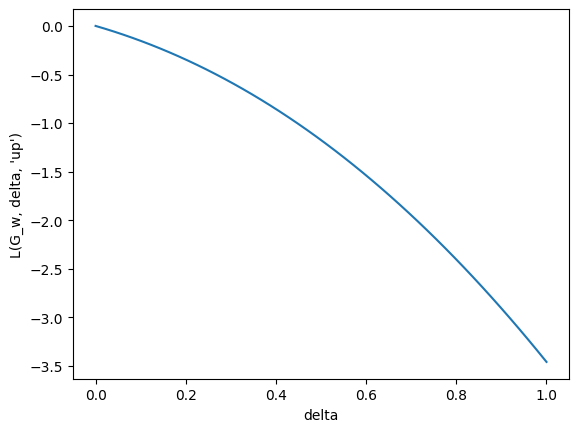

In [76]:
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

In [93]:
green

tensor([0.2482, 0.1642, 0.2240, 0.2520, 0.1952, 0.2380, 0.2122, 0.1760, 0.0852])

In [11]:

def pLM(word1, tokenizer, soft_logits):
    # word 1 and word 2 can also be whole sentences, expandable.
    word1tok = tokenizer.convert_tokens_to_ids(word1)
    prob = soft_logits[:,word1tok]
    return prob

In [103]:
L = torch.sum(deltas - torch.log(expdelta * green + red))
L

tensor(-0.0057)

In [ ]:

# for word in word_dict.keys():
#     greensum = 0 
#     redsum = 0
#     word2tok = tokenizer.convert_tokens_to_ids(word)
#     with torch.inference_mode():
#         output = model(torch.tensor([[word2tok]]))
#     soft_next_token_logits = torch.softmax(output.logits[0, -1, :], -1) 
    
#     for wdash in greenlist_w:
#         greensum += pLM(wdash, tokenizer, soft_next_token_logits)

#     for wdash in redlist_w:
#         redsum += pLM(wdash, tokenizer, soft_next_token_logits)
    
#     Lgrprod *= greensum * expdelta + redsum
#     if w in greenlist_w:
#         Ldelta += delta

# L = Ldelta - torch.log(Lgrprod)
# print(L)

In [62]:
deltaarr = torch.arange(0, 1, 0.01)
# deltaarr
Larr = L_Gw(deltaarr, 'Ġup', word_dict_nw, watermark_processor, tokenizer, model)


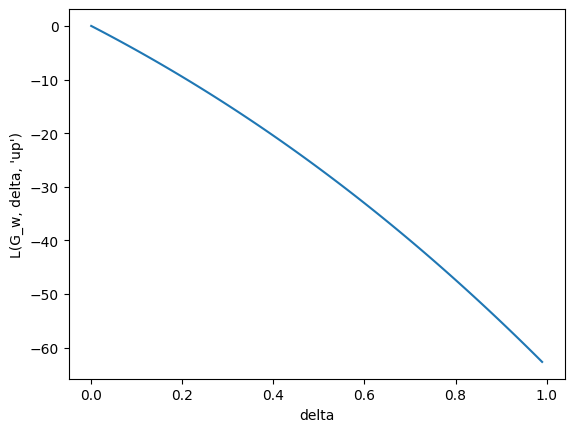

In [63]:
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

In [45]:
## L gradient descent

optim = torch.optim.SGD()

tensor([[  113,  1711,    21,   269,  3035,   113,  1437,  1437,    22, 14783,
            38,   218,    75,   216,   932,    59,   930,     8,    38,  3996,
             5,   569,   113,  1437,  1437,    22,   100,   218,    75,   216,
           932,    59,   930,   113,  1437,  1437,    22,  2847,    99,    32,
            47,   608,    19,   110,  1730,  1917,  1437,  1437,    22,   100,
           437,  6908,   120,   106,     7,  3836,   113, 50118,   243,    18,
            67,     5,   275,  2214,    11,     5,  1445,  2642,   328,     2]])
